# Financial index as the output of an ML model

* Sesión del 26/08/2020 a las 11:00am

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import randn, random, seed

In [6]:
%config InlineBackend.figure_format = "retina"

In [15]:
seed(3141)
n_components = 20
S0 = np.abs(100 + randn(20) * 100)

$$
    S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right)
$$

In [17]:
seed(314)
n_steps = 365 * 2
t = np.linspace(0,3,n_steps)
mus = np.abs(randn(n_components) * 0.2)
sigmas = np.abs(randn(n_components) * 0.45) + 0.1
dt = 1 / 365

In [19]:
sigmas

array([0.93972468, 0.38638629, 0.44241239, 1.29882387, 0.17567684,
       0.18161463, 0.69461156, 0.29701868, 0.18854163, 0.78830559,
       0.25186618, 0.53261714, 0.20410096, 0.61625125, 0.2903254 ,
       0.69874613, 0.51752522, 0.14737593, 0.59390048, 0.4916714 ])

In [20]:
St = (np.exp((mus[None, :] - sigmas[None, :] ** 2 / 2) * dt +
             sigmas[None, :] * randn(n_steps, n_components) * np.sqrt(dt)))
index = pd.date_range("2019-01-01", periods=n_steps)
St = pd.DataFrame(St, index=index)
St = S0[None, :] * St.cumprod(axis=0)

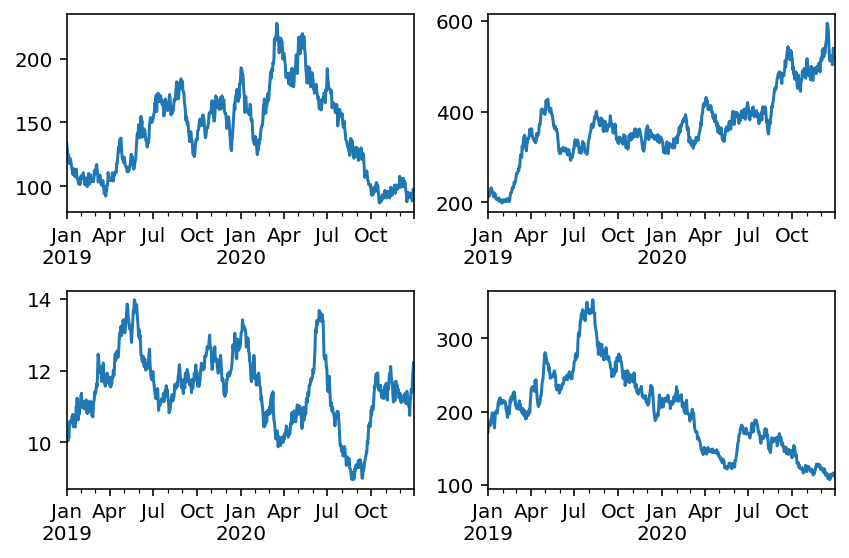

In [662]:
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
choices = [18, 2, 14, 19]

for axi, ix in zip(ax, choices):
    St[ix].plot(ax=axi)
plt.tight_layout()

In [23]:
from numpy.random import beta

In [24]:
seed(3141)
weights = beta(2, 5, n_components)
weights = weights / weights.sum()

Para una regresión lineal
$$
    y = w_1x_1 + \ldots + w_M x_M + \epsilon
$$

In [25]:
weights

array([0.08010599, 0.03200767, 0.03771154, 0.05474464, 0.02769994,
       0.05162548, 0.04646214, 0.03476687, 0.0509825 , 0.07070131,
       0.01557193, 0.04093175, 0.0285744 , 0.05402046, 0.04448652,
       0.05058782, 0.04902726, 0.09043948, 0.06241092, 0.07714137])

In [41]:
etf = (St.diff(axis=0).fillna(100) * weights[None, :]).cumsum(axis=0).sum(axis=1)
etf.name = "ETF"

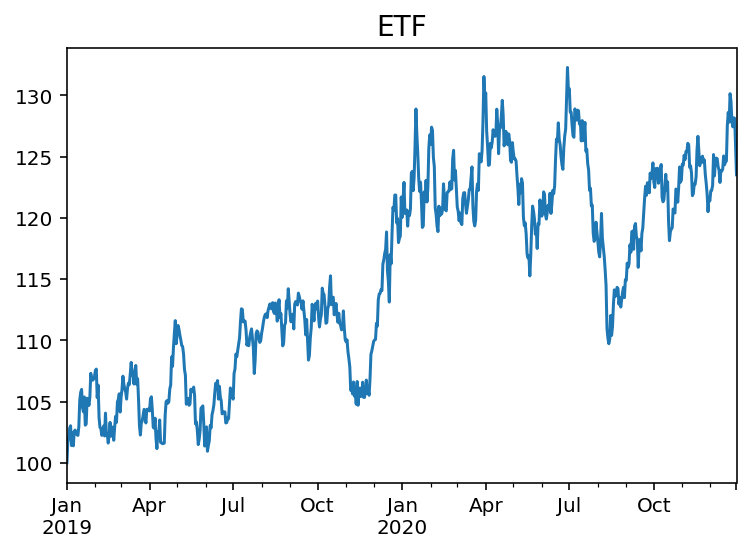

In [42]:
etf.plot()
plt.title("ETF", fontsize=14);

## Fitting an ML model to the ETF

In [54]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

returns = St.diff().dropna()
X = returns.join(etf.diff()[1:])

Xtrain = X[:-100]
Xtrain, ytrain = Xtrain.drop("ETF", axis=1), Xtrain["ETF"]

Xtest = X[-100:]
Xtest, ytest = Xtest.drop("ETF", axis=1), Xtest["ETF"]

In [81]:
%%time
from sklearn.model_selection import GridSearchCV

params_el = {
    "alpha": [0.01, 0.05, 0.1, 0.5, 1],
    "l1_ratio": [0.05, 0.1, 0.3, 0.5, 0.7],

}

model = GridSearchCV(ElasticNet(), params_el)

model.fit(Xtrain, ytrain)

CPU times: user 4.69 s, sys: 4.6 s, total: 9.29 s
Wall time: 9.28 s


GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1],
                         'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7]})

In [82]:
model.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.05)

In [733]:
params_el = {
    "alpha": [0.1, 0.5, 1],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7],

}

params_rf = {
    "n_estimators": [50, 100, 500],
    "max_features": [2, 5, 10, "auto"]
}

In [83]:
!ls

dtrees-svm.ipynb  index-model-ml.ipynb	magician.ipynb	small-pandas.ipynb


In [85]:
import pickle
with open("mi_modelo.pkl", "wb") as f:
    pickle.dump(model, f)

In [89]:
with open("mi_modelo.pkl", "rb") as f:
    model_copy = pickle.load(f)

In [734]:
model_el = GridSearchCV(ElasticNet(), param_grid=params_el)
model_rf = GridSearchCV(RandomForestRegressor(), param_grid=params_rf)
model_lr = LinearRegression()

In [735]:
model_el.fit(Xtrain, ytrain)
model_rf.fit(Xtrain, ytrain)
model_lr.fit(Xtrain, ytrain)

LinearRegression()

In [736]:
yhat_el = model_el.predict(Xtest)
yhat_rf = model_rf.predict(Xtest)
yhat_lr = model_lr.predict(Xtest)

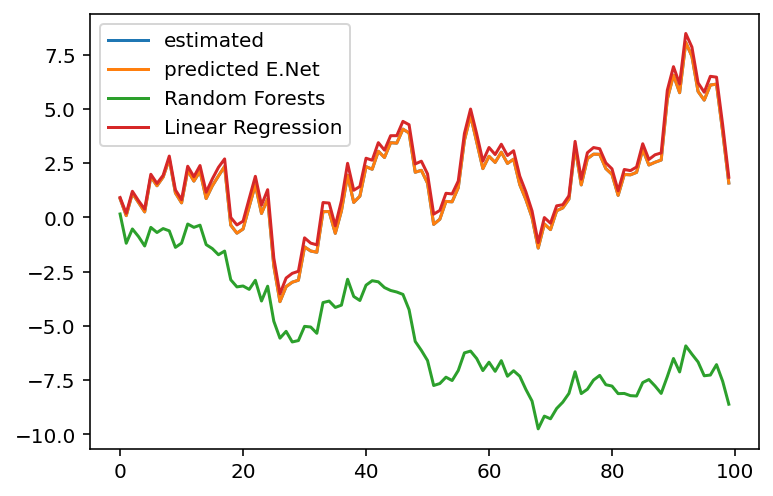

In [740]:
fig, ax = plt.subplots(1, 1)
ax.plot(yhat.cumsum(), label="estimated")
plt.plot(yhat_el.cumsum(), label="predicted E.Net")
plt.plot(yhat_rf.cumsum(), label="Random Forests")
plt.plot(yhat_lr.cumsum(), label="Linear Regression")
plt.legend()

## Modelo del Índice / ETF

In [99]:
import seaborn as sns

<AxesSubplot:>

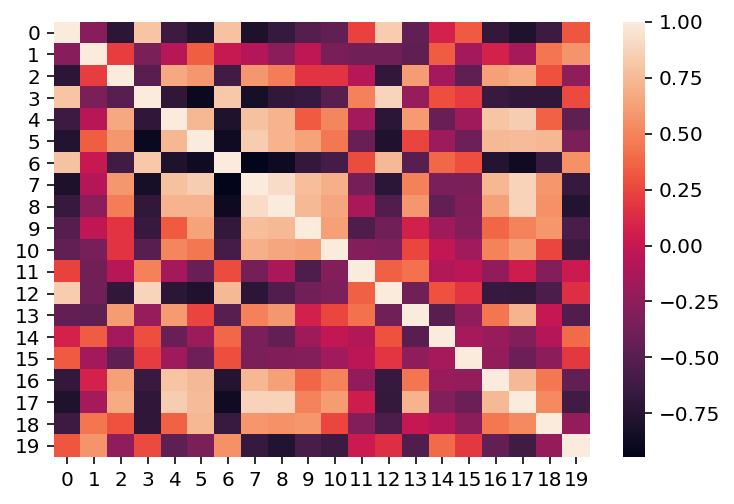

In [100]:
sns.heatmap(Xtrain.cumsum(axis=0).corr())

In [102]:
Xtrain_prices = Xtrain.cumsum(axis=0)
Xtrain_prices_corr = Xtrain_prices.corr()

In [106]:
Xtrain_prices_corr.values[np.diag_indices_from(Xtrain_prices_corr)] = 0

In [121]:
target_ix = 18
pair_ix = Xtrain_prices_corr[target_ix].idxmax()

<AxesSubplot:>

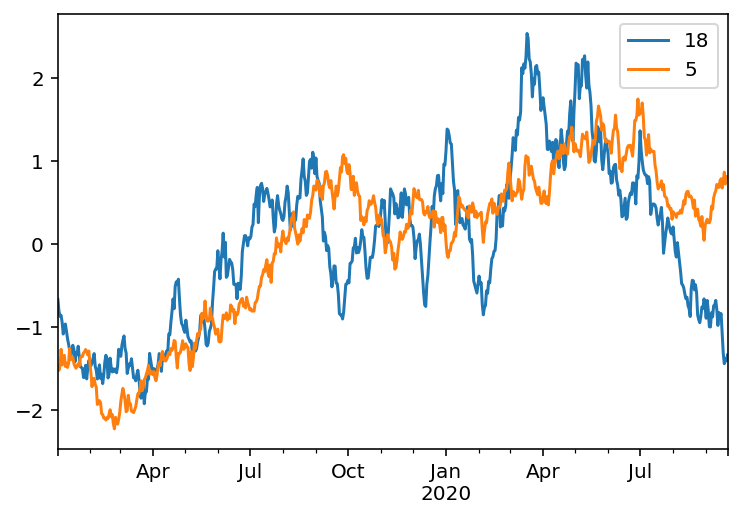

In [122]:
sample = Xtrain_prices[[target_ix, pair_ix]]
sample = (sample - sample.mean(axis=0).values) / sample.std(axis=0).values
sample.plot()

## Recuperando coeficientes

### Regresión Lineal

In [137]:
# Para un trimestre
Xtrain_quarter = Xtrain[0 * 92: 92 * 1]
ytrain_quarter = ytrain[0: 92]

In [138]:
subset_cols = Xtrain.sample(15, axis=1, random_state=31415).columns.values

In [139]:
lr = LinearRegression()
lr.fit(Xtrain_quarter[subset_cols], ytrain_quarter)
lr.coef_

array([ 0.01358329,  0.07195751,  0.13315311,  0.01805333,  0.0128922 ,
        0.0367443 ,  0.07474313,  0.05918716,  0.08809402, -0.03388113,
        0.04867344,  0.07005513,  0.11227872,  0.04343354,  0.04334313])

In [140]:
lr.coef_.sum()

0.7923108905706899

In [136]:
weights_model = lr.coef_

In [164]:
yhat_quarter = (Xtrain[subset_cols][92: 92 * 2] * weights_model).sum(axis=1)

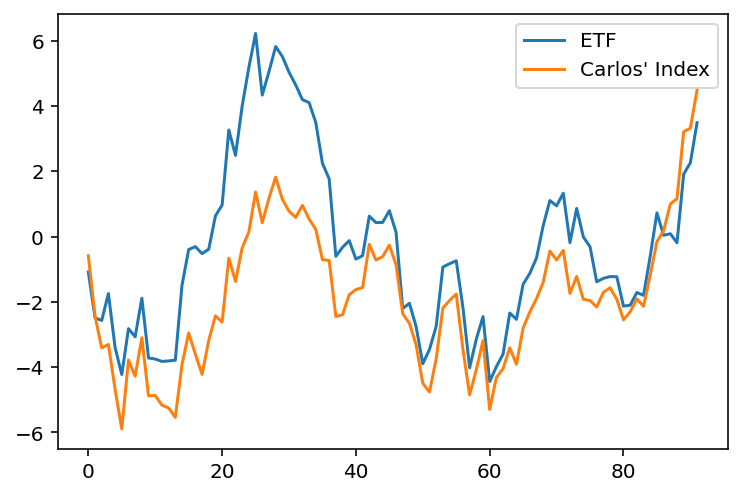

In [166]:
plt.plot(ytrain[92: 2 * 92].values.cumsum(), label="ETF")
plt.plot(yhat_quarter.cumsum().values, label="Carlos' Index")
plt.legend()

## GridSearchCV over configuration

In [ ]:
([0 * 92, (0 + 1) * 92], [92, 2 * 92]), ([92, 2 * 92], [92 * 2, 3 * 92])

In [177]:
ncv = Xtrain.shape[0] // 92 - 1
ncv

5

In [ ]:
[1, 2, 4, 8, 16, ...]

In [175]:
potencias = []
for i in range(1, 11):
    potencias.append(i ** 2)

$$
    \{f(x) : x \in X\}
$$

In [179]:
cv_list = [(np.arange(92 * i, 92 * (1 + i)), np.arange(92 * (1 + i), 92 * (2 + i))) for i in range(ncv)]

In [216]:
cv_list

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
         85, 86, 87, 88, 89, 90, 91]),
  array([ 92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
         105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
         118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
         131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
         144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
         157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
         170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
         183])),
 (array([ 92,  93,  94,  95,  96,  97,  9

In [209]:
model_weights = []
timestamps = []
for ix_train, ix_test in cv_list:
    my_model = LinearRegression()
    timestamp = Xtrain[subset_cols].iloc[ix_train].index[0]
    my_model.fit(Xtrain[subset_cols].iloc[ix_train], ytrain.iloc[ix_train])
    timestamps.append(timestamp)
    model_weights.append(my_model.coef_)

In [210]:
timestamps

[Timestamp('2019-01-02 00:00:00', freq='D'),
 Timestamp('2019-04-04 00:00:00', freq='D'),
 Timestamp('2019-07-05 00:00:00', freq='D'),
 Timestamp('2019-10-05 00:00:00', freq='D'),
 Timestamp('2020-01-05 00:00:00', freq='D')]

In [217]:
pd.DataFrame(model_weights, index=timestamps)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2019-01-02,0.013583,0.071958,0.133153,0.018053,0.012892,0.036744,0.074743,0.059187,0.088094,-0.033881,0.048673,0.070055,0.112279,0.043434,0.043343
2019-04-04,0.025028,0.035335,0.097523,-0.083969,-0.179425,0.055505,0.076293,-0.004627,0.089161,0.020027,0.056432,0.075643,0.200250,0.035801,0.039187
2019-07-05,0.033208,0.066035,-0.005971,0.036124,0.253366,0.045081,0.072404,0.046735,0.089836,0.024042,0.055133,0.059829,0.145756,0.046559,0.039488
2019-10-05,0.011768,0.071546,0.094662,-0.007485,-0.325002,0.013959,0.077631,0.051512,0.100750,0.005001,0.051186,0.062050,0.099848,0.040753,0.035767
2020-01-05,0.016801,0.070774,0.088425,0.032656,0.205231,0.041346,0.076439,0.047420,0.093591,0.025305,0.052937,0.056115,0.082409,0.037030,0.034934


<AxesSubplot:>

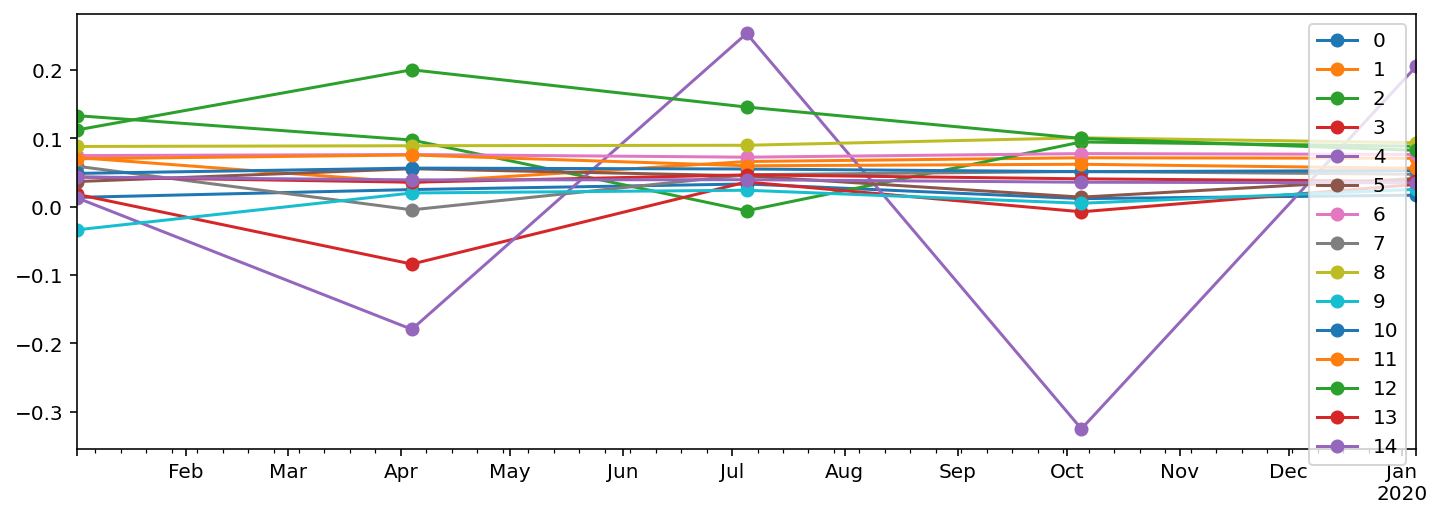

In [215]:
pd.DataFrame(model_weights, index=timestamps).plot(marker="o", figsize=(12, 4))

In [ ]:
[0, 1] => [1, 2] [2, 3] [3, 4] [4, 5]
[1, 2] => [2, 3] [3, 4] [4, 5]
[2, 3] => [3, 4] [4, 5]
[3, 4] => [4, 5]

In [186]:
params_el = {
    "alpha": [0.01, 0.05, 0.1, 0.5, 1],
    "l1_ratio": [0.05, 0.1, 0.3, 0.5, 0.7],

}

model = GridSearchCV(ElasticNet(), params_el, cv=cv_list)

model.fit(Xtrain[subset_cols], ytrain)

GridSearchCV(cv=[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91]),
                  array([ 92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 10...
       486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
       499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511,
       512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524,
       525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550,
       551]))],
             estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.05, 0.

In [187]:
model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.05)

In [188]:
model.best_score_

0.9053486757780593

In [189]:
model.best_estimator_.coef_

array([ 0.01584606,  0.07017697,  0.01819392,  0.        , -0.        ,
        0.04140136,  0.07469867,  0.04297559,  0.08880125,  0.00744959,
        0.0523192 ,  0.06188626,  0.09211855,  0.04360206,  0.0374844 ])

In [191]:
weights_model = model.best_estimator_.coef_.sum()
weights_model = weights_model / weights_model.sum()